In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# StandfordCars dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize([256, 256]),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

whole_train_dataset = torchvision.datasets.StanfordCars(root="./data", split="train", transform=transform,
                                            download=True)
test_dataset = torchvision.datasets.StanfordCars(root="./data", split="test", transform=transform, download=True)
train_dataset, valid_dataset = torch.utils.data.random_split(whole_train_dataset, [7144, 1000])

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_train.tgz to data/stanford_cars
Using downloaded and verified file: data/stanford_cars/car_devkit.tgz
Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_test.tgz to data/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [ ]:
batch_size = 64

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=whole_train_dataset, batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                           shuffle=True)

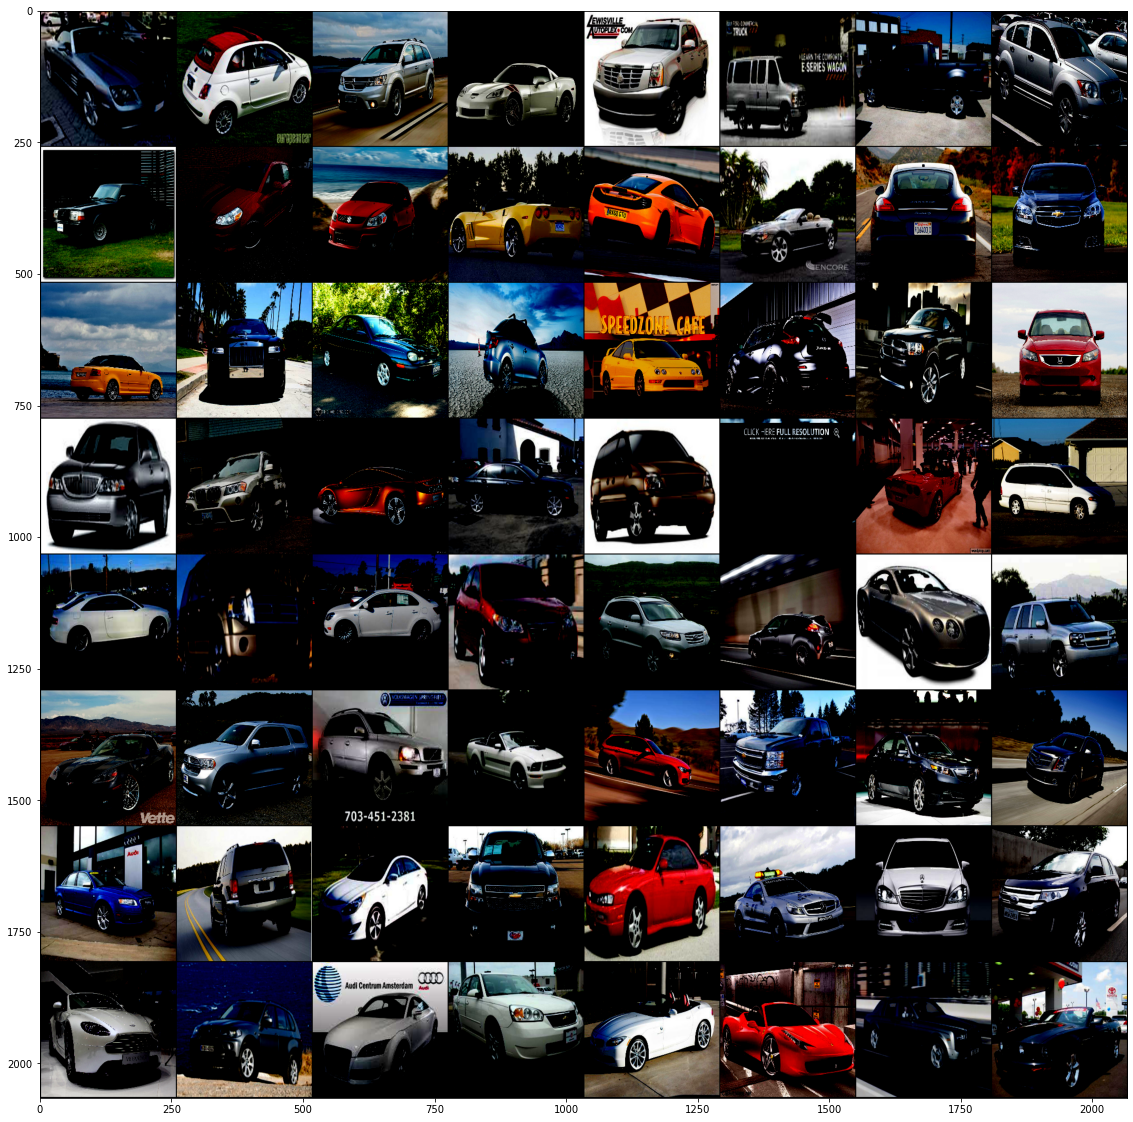

In [ ]:
plt.subplots(1,1,figsize=[20,20])
image, label = iter(train_loader).next()
grid_image = torchvision.utils.make_grid(image)
permuted_image = torch.permute(grid_image, (1,2,0))
plt.imshow(permuted_image)
plt.show()

In [ ]:
# CNN 2layers
num_class = 196
class ConvNet2layer(nn.Module):
    def __init__(self, num_class=10):
        super(ConvNet2layer, self).__init__()
        self._layer1Con = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same") # Output size = (32, 256, 256)
        self._layer1ReLU = nn.ReLU() # Output size = (32, 256, 256)
        self._layer1MaxPooling = nn.MaxPool2d(kernel_size=4, stride=4)  # Output size = (32, 64, 64)

        self._layer2Con = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same") # Output size = (64, 64, 64)
        self._layer2ReLU = nn.ReLU() # Output size = (64, 64, 64)
        self._layer2MaxPooling = nn.MaxPool2d(kernel_size=4, stride=4)  # Output size = (64, 16, 16)

        self._layer3 = nn.Linear(in_features=64*16*16, out_features=4096)
        self._layer4 = nn.Linear(in_features=4096, out_features=num_class)

        self._layer1Con_out = None
        self._layer1ReLU_out = None
        self._layer1MaxPooling_out = None

        self._layer2Con_out = None
        self._layer2ReLU_out = None
        self._layer2MaxPooling_out = None

        self._layer2_out = None
        self._layer3_out = None
        self._layer4_out = None

    def forward(self, x):
        self._layer1Con_out = self._layer1Con(x)
        self._layer1ReLU_out = self._layer1ReLU(self._layer1Con_out)
        self._layer1MaxPooling_out = self._layer1MaxPooling(self._layer1ReLU_out)

        self._layer2Con_out = self._layer2Con(self._layer1MaxPooling_out)
        self._layer2ReLU_out = self._layer2ReLU(self._layer2Con_out)
        self._layer2MaxPooling_out = self._layer2MaxPooling(self._layer2ReLU_out)

        self._layer3_out = self._layer3(self._layer2MaxPooling_out.reshape(self._layer2MaxPooling_out.size(0), -1))
        self._layer4_out = self._layer4(self._layer3_out)
        return self._layer4_out
    
    def get_layer(self, num_layer):
      if num_layer == 1:
        return self._layer1_out
      elif num_layer == 2:
        return self._layer2_out
      elif num_layer == 3:
        return self._layer3_out
      elif num_layer == 4:
        return self._layer4_out

In [ ]:
def train(model, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch=30, n_no_improvement=5):
    total_steps = len(train_loader)
    train_accuracy = 0
    train_accuracy_list = []
    valid_accuracy = 0
    best_valid_accuracy = 0
    no_improvement = 0
    valid_accuracy_list = []
    loss_list = []
    for epoch in range(num_epoch):
        for i, (image, label) in enumerate(train_loader):
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        model.eval()
        with torch.no_grad():
            train_correct = 0
            train_total = 0
            for image, label in train_loader:
                image = image.to(device)
                label = label.to(device)
                
                output = model(image)
                _, predicted = torch.max(output.data, 1)
                train_total += label.size(0)
                train_correct += (predicted == label).sum().item()
        train_accuracy = train_correct/train_total*100
        train_accuracy_list.append(train_accuracy)
        
        with torch.no_grad():
            valid_correct = 0
            valid_total = 0
            for image, label in valid_loader:
                image = image.to(device)
                label = label.to(device)
                
                output = model(image)
                _, predicted = torch.max(output.data, 1)
                valid_total += label.size(0)
                valid_correct += (predicted == label).sum().item()
        valid_accuracy = valid_correct/valid_total*100
        valid_accuracy_list.append(valid_accuracy)
        print(f"Epoch[{epoch+1}/{num_epoch}], Loss:{loss.item()}, Training Accuracy: {train_accuracy}%, Validation Accuaracy: {valid_accuracy}%")
        if valid_accuracy > best_valid_accuracy:
          best_valid_accuracy = valid_accuracy
          no_improvement = 0
        else:
          no_improvement += 1
        if no_improvement == n_no_improvement:
          break
    return model, loss_list, train_accuracy_list, valid_accuracy_list

# Learning curve
def learning_curve(save=False, path=None, title=None, train_accuracy_list=None, valid_accuracy_list=None, loss_list=None):
    fig, ax = plt.subplots(1,1,figsize=[8,8])
    ax.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, marker=".", label="training ")
    ax.plot([i for i in range(len(valid_accuracy_list))], valid_accuracy_list, marker=".", label="validation ")
    ax.plot([i for i in range(len(loss_list))], loss_list, marker=".", label="training loss")
    ax.set_title(title)
    ax.set_xlabel("Epoch") 
    ax.set_ylabel("Accuracy(%)")
    plt.legend()
    if save == True:
      fig.savefig(path)

Epoch[1/30], Loss:5.145489692687988, Training Accuracy: 2.038310412573674%, Validation Accuaracy: 0.7000000000000001%
Epoch[2/30], Loss:5.012485980987549, Training Accuracy: 2.136542239685658%, Validation Accuaracy: 2.3%
Epoch[3/30], Loss:4.2869439125061035, Training Accuracy: 5.083497053045186%, Validation Accuaracy: 4.5%
Epoch[4/30], Loss:3.4634881019592285, Training Accuracy: 9.651277013752456%, Validation Accuaracy: 11.200000000000001%
Epoch[5/30], Loss:3.422497272491455, Training Accuracy: 19.351669941060905%, Validation Accuaracy: 17.5%
Epoch[6/30], Loss:1.6888097524642944, Training Accuracy: 52.25933202357563%, Validation Accuaracy: 50.9%
Epoch[7/30], Loss:0.6533591151237488, Training Accuracy: 71.75834970530451%, Validation Accuaracy: 70.3%
Epoch[8/30], Loss:1.3210662603378296, Training Accuracy: 52.40667976424361%, Validation Accuaracy: 53.400000000000006%
Epoch[9/30], Loss:0.14016388356685638, Training Accuracy: 89.83300589390963%, Validation Accuaracy: 90.5%
Epoch[10/30], Lo

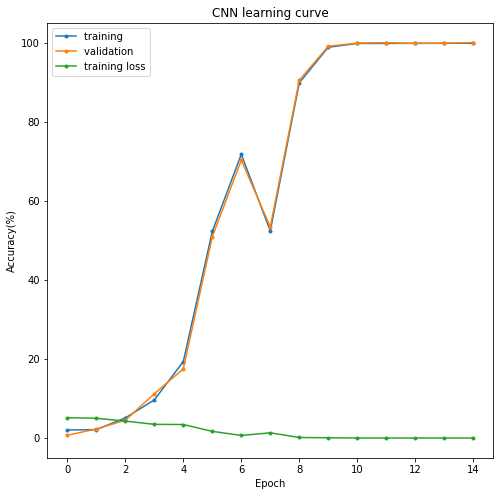

In [ ]:
cnn_model = ConvNet2layer(num_class=196).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(params=cnn_model.parameters(), lr=learning_rate)
train_loader = train_loader
valid_loader = valid_loader
num_epoch = 30
n_no_improvement = 3
cnn_model, loss_list, train_accuracy_list, valid_accuracy_list = train(cnn_model, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch, n_no_improvement)
learning_curve(save=True, path="cnn_model_original_lc", train_accuracy_list=train_accuracy_list, valid_accuracy_list=valid_accuracy_list, loss_list=loss_list, title="CNN learning curve")

In [ ]:
torch.save(cnn_model, "standfordcars_model")
# files.download("standfordcars_model")

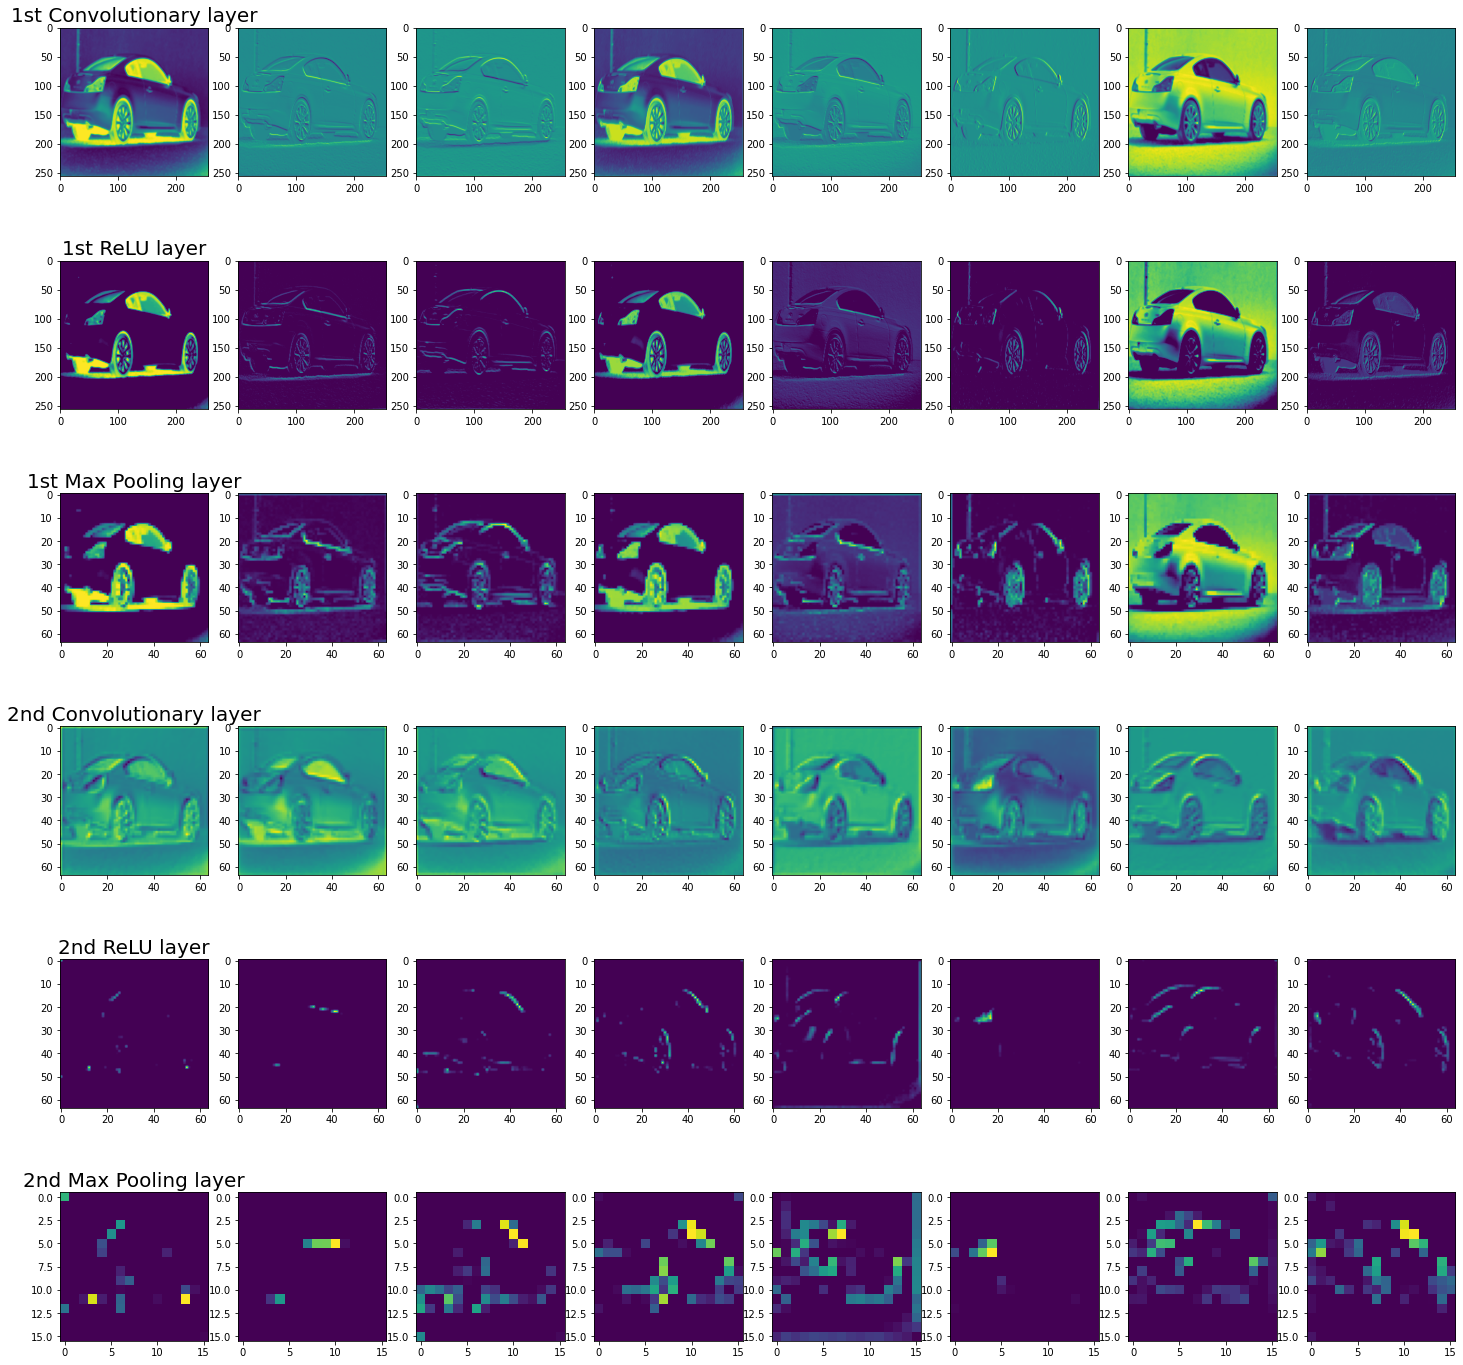

In [ ]:
selected_image, selected_target = train_dataset.__getitem__(1104)
selected_image = torch.unsqueeze(selected_image, 0)
selected_image = selected_image.to(device)
_ = cnn_model(selected_image)

fig, ax = plt.subplots(6,8, figsize=[25,25])
ax[0][0].set_title("1st Convolutionary layer", fontsize=20)
ax[1][0].set_title("1st ReLU layer", fontsize=20)
ax[2][0].set_title("1st Max Pooling layer", fontsize=20)
ax[3][0].set_title("2nd Convolutionary layer", fontsize=20)
ax[4][0].set_title("2nd ReLU layer", fontsize=20)
ax[5][0].set_title("2nd Max Pooling layer", fontsize=20)
feature_maps = [cnn_model._layer1Con_out, cnn_model._layer1ReLU_out, cnn_model._layer1MaxPooling_out,
                cnn_model._layer2Con_out, cnn_model._layer2ReLU_out, cnn_model._layer2MaxPooling_out]

for row in range(6):
  feature_map = feature_maps[row]
  for col in range(8):
    ax[row][col].imshow(feature_map[0][col].detach().cpu())

In [ ]:
fig.savefig("stanfordcars_filters")